# Lab 5 Solution

In [16]:
import nasdaqdatalink # You could also do something like: import nasdaqdatalink as ndl
import pandas_datareader as pdr

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib as mpl 

import matplotlib.pyplot as plt

import seaborn as sns

## Part 3

In [17]:
dsf = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/crsp_022722.csv')
dsf = dsf[(dsf['PRC'].notna()) & (dsf['RET'].notna())]
dsf['PRC_ADJ'] = dsf['PRC'] / dsf['CFACPR']
dsf['date']=pd.to_datetime(dsf['date'], format='%Y%m%d')

dsf_ret_wide = dsf.pivot_table(index = 'date', columns = 'TICKER', values = 'RET')
dsf_price_wide = dsf.pivot_table(index = 'date', columns = 'TICKER', values = 'PRC_ADJ')


In [18]:
dsf_ret_wide


TICKER,AAPL,TLT,XOM
date,,,
2019-01-02,0.001141,0.005267,0.021997
2019-01-03,-0.099607,0.011379,-0.015354
2019-01-04,0.042689,-0.011575,0.036870
2019-01-07,-0.002226,-0.002948,0.005200
2019-01-08,0.019063,-0.002628,0.007271
...,...,...,...
2021-12-27,0.022975,0.002424,0.014258
2021-12-28,-0.005767,-0.003963,-0.003232
2021-12-29,0.000502,-0.010925,-0.008753


In [19]:
# Define function

def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
    dt = T/N # One day
    dW = np.random.normal(scale = np.sqrt(dt), 
        size=(n_sims, N))  # The random part
    W = np.cumsum(dW, axis=1)
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
        + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

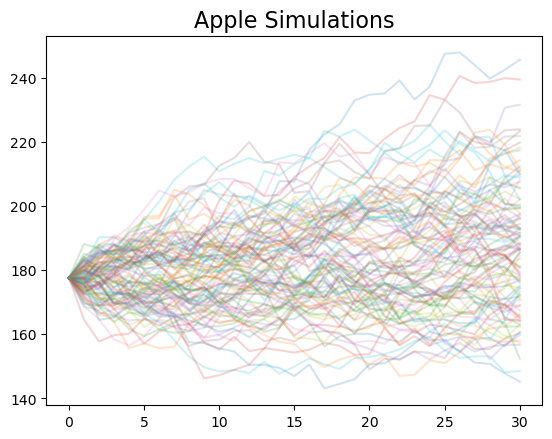

In [20]:
# Apple

T = 30 # How long is our simulation? Let's do 31 days (0 to 30 the way Python counts)
N = 30 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
S_0 = dsf_price_wide.AAPL[-1] # initial stock price
N_SIM = 100      # How many simulations to run?
mu = dsf_ret_wide.AAPL.mean()
sigma = dsf_ret_wide.AAPL.std()

gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)

ax.set_title('Apple Simulations', fontsize=16);

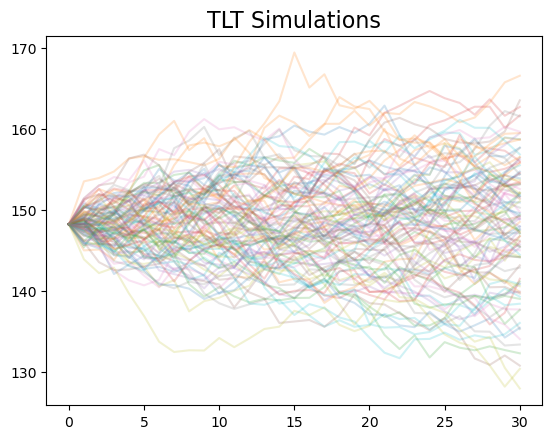

In [21]:
# TLT

T = 30 # How long is our simulation? Let's do 31 days (0 to 30 the way Python counts)
N = 30 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
S_0 = dsf_price_wide.TLT[-1] # initial stock price
N_SIM = 100      # How many simulations to run?
mu = dsf_ret_wide.TLT.mean()
sigma = dsf_ret_wide.TLT.std()

gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)

ax.set_title('TLT Simulations', fontsize=16);

## Part 4

In [22]:
#Set-up GDP
gdp = nasdaqdatalink.get('FRED/GDP')
gdp.head()

gdp.index = gdp.index - dt.timedelta(days=1)
gdp = gdp.resample('M').ffill()

gdp.rename(columns = {'Value':'gdp'}, inplace = True)

gdp

,gdp
Date,
1946-12-31,243.164
1947-01-31,243.164
1947-02-28,243.164
1947-03-31,245.968
1947-04-30,245.968
...,...
2021-05-31,22740.959
2021-06-30,23202.344
2021-07-31,23202.344


In [23]:
#Set-up UMich

umich = nasdaqdatalink.get('UMICH/SOC1')

umich.rename(columns = {'Index':'conf'}, inplace = True)
umich = umich.resample('M').ffill()

umich


,conf
Date,
1952-11-30,86.2
1952-12-31,86.2
1953-01-31,86.2
1953-02-28,90.7
1953-03-31,90.7
...,...
2022-10-31,59.9
2022-11-30,56.8
2022-12-31,59.7


In [24]:
# Set-up unrate

unrate = nasdaqdatalink.get('FRED/UNRATE')

unrate.info()

unrate.index = unrate.index -dt.timedelta(days=1)

unrate = unrate.resample('M').ffill()

unrate.rename(columns = {'Value':'unrate'}, inplace = True)
unrate



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889 entries, 1948-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   889 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


,unrate
Date,
1947-12-31,3.4
1948-01-31,3.8
1948-02-29,4.0
1948-03-31,3.9
1948-04-30,3.5
...,...
2021-08-31,4.7
2021-09-30,4.6
2021-10-31,4.2


In [25]:
gdp.index

DatetimeIndex(['1946-12-31', '1947-01-31', '1947-02-28', '1947-03-31',
               '1947-04-30', '1947-05-31', '1947-06-30', '1947-07-31',
               '1947-08-31', '1947-09-30',
               ...
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30'],
              dtype='datetime64[ns]', name='Date', length=898, freq='M')

## Part 4 - Join Together

In [26]:
df_inner = pd.merge(gdp, umich, how='inner', on='Date') #See how the index has the name Date? So, you can merge on it like a variable/column.
df_inner = pd.merge(df_inner, unrate, how='inner', on='Date')

df_inner


,gdp,conf,unrate
Date,,,
1952-11-30,380.812,86.2,2.7
1952-12-31,387.980,86.2,2.9
1953-01-31,387.980,86.2,2.6
1953-02-28,387.980,90.7,2.6
1953-03-31,391.749,90.7,2.7
...,...,...,...
2021-05-31,22740.959,82.9,5.9
2021-06-30,23202.344,85.5,5.4
2021-07-31,23202.344,81.2,5.2


In [27]:
df_outer = pd.merge(gdp, umich, how='outer', on='Date')
df_outer = pd.merge(df_outer, unrate, how='outer', on='Date')

df_outer

,gdp,conf,unrate
Date,,,
1946-12-31,243.164,NaN,NaN
1947-01-31,243.164,NaN,NaN
1947-02-28,243.164,NaN,NaN
1947-03-31,245.968,NaN,NaN
1947-04-30,245.968,NaN,NaN
...,...,...,...
2022-10-31,NaN,59.9,NaN
2022-11-30,NaN,56.8,NaN
2022-12-31,NaN,59.7,NaN


## Part 5 - Plot Using Pandas

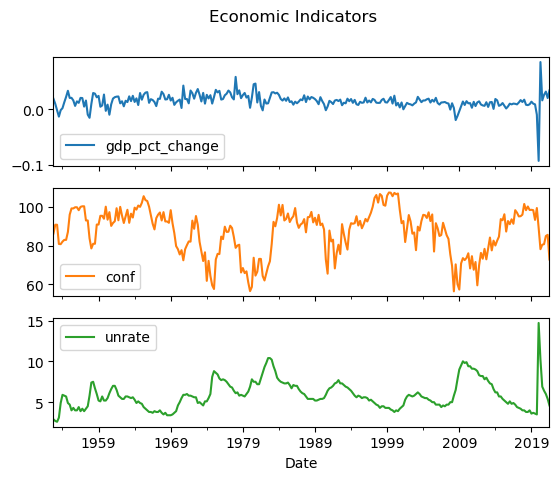

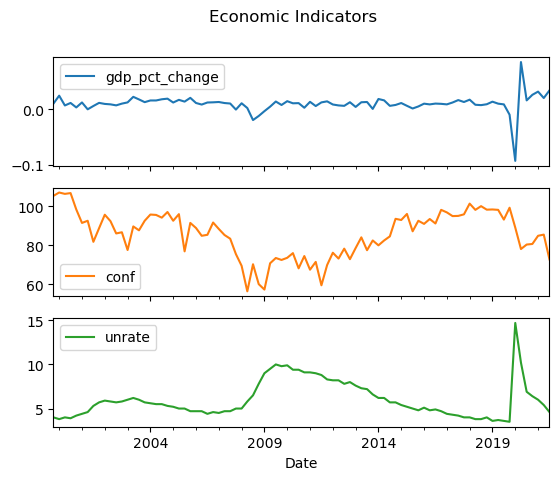

In [28]:
df_inner['gdp_pct_change'] = df_inner['gdp'].pct_change()
df_inner['conf_pct_change'] = df_inner['conf'].pct_change()
df_inner['unrate_pct_change'] = df_inner['unrate'].pct_change()

df_inner_q = df_inner.asfreq('Q')
df_inner_q

df_inner_q[['gdp_pct_change', 'conf', 'unrate']].plot(subplots = True, title = 'Economic Indicators');

# Select just since December 1999

df_inner_q.loc['1999-12-31':,['gdp_pct_change', 'conf', 'unrate']].plot(subplots = True, title = 'Economic Indicators');


## Part 6 - Correlation

In [29]:
df_inner_q.corr()


,gdp,conf,unrate,gdp_pct_change,conf_pct_change,unrate_pct_change
gdp,1.000000,-0.038277,0.083334,-0.242450,0.134798,0.069639
conf,-0.038277,1.000000,-0.552944,-0.015374,0.058226,-0.039180
unrate,0.083334,-0.552944,1.000000,-0.051310,0.055101,0.297960
gdp_pct_change,-0.242450,-0.015374,-0.051310,1.000000,0.076351,-0.582502
conf_pct_change,0.134798,0.058226,0.055101,0.076351,1.000000,-0.195832
unrate_pct_change,0.069639,-0.039180,0.297960,-0.582502,-0.195832,1.000000


<AxesSubplot:>

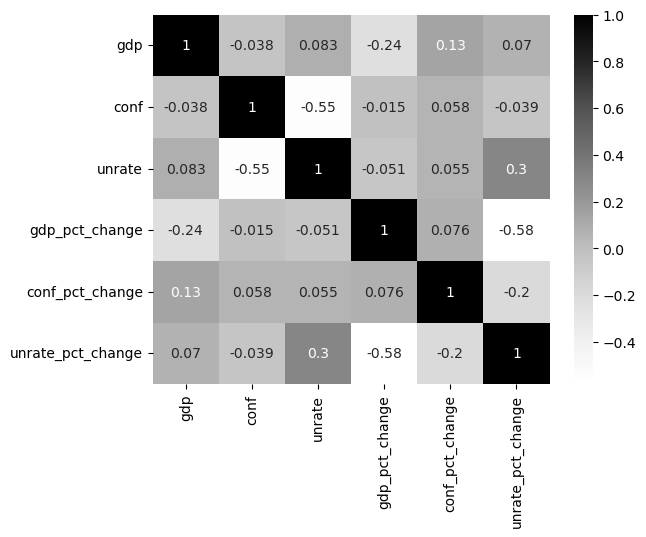

In [30]:
sns.heatmap(df_inner_q.corr(), annot = True, cmap = 'Greys')

## Part 7 - Wide to Long

In [31]:
df_inner_q.reset_index(inplace=True)
df_inner_q


,Date,gdp,conf,unrate,gdp_pct_change,conf_pct_change,unrate_pct_change
0,1952-12-31,387.980,86.2,2.9,0.018823,0.000000,0.074074
1,1953-03-31,391.749,90.7,2.7,0.009714,0.000000,0.038462
2,1953-06-30,391.171,90.7,2.6,-0.001475,0.000000,0.040000
3,1953-09-30,385.970,80.8,3.1,-0.013296,0.000000,0.068966
4,1953-12-31,385.345,80.7,4.9,-0.001619,0.000000,0.088889
...,...,...,...,...,...,...,...
271,2020-09-30,21477.597,80.4,6.9,0.016038,0.085020,-0.126582
272,2020-12-31,22038.226,80.7,6.4,0.026103,0.049415,-0.044776
273,2021-03-31,22740.959,84.9,6.0,0.031887,0.105469,0.000000
274,2021-06-30,23202.344,85.5,5.4,0.020289,0.031363,-0.084746


In [32]:
df_inner_q_long = df_inner_q.melt(id_vars = 'Date')

df_inner_q_long = df_inner_q.melt(id_vars = 'Date', var_name='indicator')



In [33]:
df_inner_q_long_levels = df_inner_q.melt(id_vars = 'Date', var_name='indicator', value_vars=['gdp', 'conf', 'unrate'])

df_inner_q_long_levels

,Date,indicator,value
0,1952-12-31,gdp,387.980
1,1953-03-31,gdp,391.749
2,1953-06-30,gdp,391.171
3,1953-09-30,gdp,385.970
4,1953-12-31,gdp,385.345
...,...,...,...
823,2020-09-30,unrate,6.900
824,2020-12-31,unrate,6.400
825,2021-03-31,unrate,6.000
826,2021-06-30,unrate,5.400
